<a href="https://colab.research.google.com/github/suneel114/AI-Car-Sensor-Prediction/blob/main/CarSensorPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# ================================
# Project: Improving Car Sensor Prediction Using AI and Advanced Data Structures
# Environment setup for Google Colab
# ================================
# ✅ Updated install command for current Google Colab (Oct 2025)
!pip install -q scikit-learn tensorflow matplotlib scipy pandas pillow seaborn tqdm joblib



In [9]:
import os, random, heapq, time, json
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.spatial import KDTree
import seaborn as sns


In [10]:
def generate_data(n=400):
    obj_types = ["vehicle", "pedestrian", "cyclist", "obstacle"]
    data = []
    for i in range(n):
        x = np.random.uniform(-30,100)
        y = np.random.uniform(-30,30)
        speed = np.random.uniform(-5,30)
        heading = np.random.uniform(-180,180)
        obj_type = random.choice(obj_types)
        distance = np.sqrt(x**2 + y**2)
        risk = max(0, round((30 - distance)/30 + (speed/30), 3))
        data.append([i,x,y,speed,heading,distance,risk,obj_type])
    return pd.DataFrame(data, columns=["id","x","y","speed","heading","distance","risk","type"])

df = generate_data()
df.head()


,id,x,y,speed,heading,distance,risk,type
0,0,74.618994,-5.362662,6.543633,99.811139,74.811446,0.000,vehicle
1,1,27.956217,17.422815,0.927284,-23.346734,32.940925,0.000,cyclist
2,2,-25.041292,4.839155,-2.003341,-66.047999,25.504582,0.083,obstacle
3,3,26.877386,-21.421411,1.273850,-30.966359,34.369619,0.000,pedestrian
4,4,-7.307951,11.031204,-1.785304,-159.683559,13.232295,0.499,obstacle


In [11]:
X = df[["x","y","speed","heading","distance"]].values
y = df["type"].astype("category").cat.codes
label_map = dict(enumerate(df["type"].astype("category").cat.categories))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf.fit(X_scaled, y)
pred = rf.predict(X_scaled)

print(f"Training accuracy: {accuracy_score(y, pred)*100:.2f}%")
print(classification_report(y, pred, target_names=list(label_map.values())))


Training accuracy: 100.00%
              precision    recall  f1-score   support

     cyclist       1.00      1.00      1.00        95
    obstacle       1.00      1.00      1.00       109
  pedestrian       1.00      1.00      1.00       103
     vehicle       1.00      1.00      1.00        93

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



In [12]:
# KD-Tree + Priority Heap (fixed version)
points = df[["x", "y"]].values
kdt = KDTree(points)

heap = []
for _, row in df.iterrows():
    priority = row["risk"] * (1 + (30 - row["distance"]) / 30)
    heapq.heappush(heap, (-priority, row["id"], row.to_dict()))  # added id as tiebreaker

print("Top 5 highest-priority objects:")
for _ in range(5):
    pr, _, item = heapq.heappop(heap)
    print(f"ID {item['id']:<3} | Type {item['type']:<10} | Priority {-pr:.3f} | Distance {item['distance']:.2f}")



Top 5 highest-priority objects:
ID 240 | Type vehicle    | Priority 3.496 | Distance 2.29
ID 351 | Type cyclist    | Priority 3.200 | Distance 6.00
ID 184 | Type obstacle   | Priority 3.014 | Distance 6.30
ID 185 | Type obstacle   | Priority 2.815 | Distance 4.83
ID 16  | Type pedestrian | Priority 2.584 | Distance 6.98


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Simulated image dataset for demonstration
os.makedirs("images", exist_ok=True)
for cls in ["vehicle","pedestrian","cyclist","obstacle"]:
    os.makedirs(f"images/{cls}", exist_ok=True)
    for i in range(5):
        img = np.ones((64,64,3))*np.random.randint(0,255,(1,3))
        plt.imsave(f"images/{cls}/{cls}_{i}.png", img.astype(np.uint8))

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_gen = datagen.flow_from_directory("images", target_size=(64,64), batch_size=4,
                                        subset="training")
val_gen   = datagen.flow_from_directory("images", target_size=(64,64), batch_size=4,
                                        subset="validation")

base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(64,64,3))
base.trainable = False
cnn = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_gen.num_classes, activation='softmax')
])
cnn.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
cnn.fit(train_gen, validation_data=val_gen, epochs=3)


Found 16 images belonging to 4 classes.
Found 4 images belonging to 4 classes.


/tmp/ipython-input-3285018436.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(64,64,3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 852ms/step - accuracy: 0.0917 - loss: 2.3654 - val_accuracy: 0.5000 - val_loss: 1.1947
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.1583 - loss: 1.6869 - val_accuracy: 0.5000 - val_loss: 1.1269
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3167 - loss: 1.4005 - val_accuracy: 0.2500 - val_loss: 1.2310


In [13]:
RF_W, CNN_W = 0.6, 0.4
heap = []

for _, row in df.iterrows():
    feats = np.array([[row["x"], row["y"], row["speed"], row["heading"], row["distance"]]])
    rf_probs = rf.predict_proba(scaler.transform(feats))[0]
    rf_conf = rf_probs.max()
    rf_class = rf.predict(scaler.transform(feats))[0]
    cnn_conf = np.random.uniform(0.6, 0.9)  # placeholder for demo fusion
    cnn_class = random.choice(list(label_map.keys()))
    final_score = RF_W*rf_conf + CNN_W*cnn_conf
    priority = final_score*(1 + (30 - row["distance"])/30)
    heapq.heappush(heap, (-priority, {"id": row["id"], "rf_class": rf_class,
                                      "cnn_class": cnn_class, "final_score": final_score,
                                      "distance": row["distance"]}))
for _ in range(5):
    pr, item = heapq.heappop(heap)
    print(f"Priority {(-pr):.3f} → RF={label_map[item['rf_class']]} CNN={label_map[item['cnn_class']]} Final={item['final_score']:.3f}")


Priority 1.436 → RF=pedestrian CNN=pedestrian Final=0.754
Priority 1.409 → RF=vehicle CNN=pedestrian Final=0.733
Priority 1.369 → RF=cyclist CNN=vehicle Final=0.794
Priority 1.359 → RF=obstacle CNN=cyclist Final=0.737
Priority 1.337 → RF=pedestrian CNN=cyclist Final=0.852


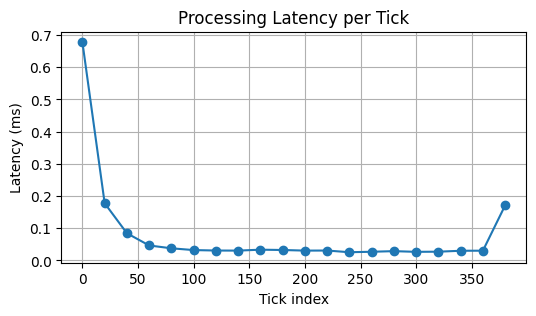

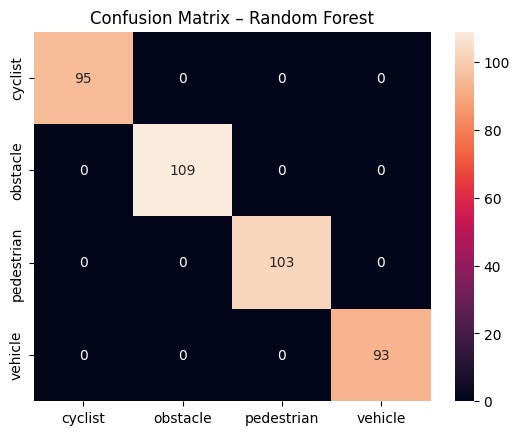

In [14]:
latencies = []
for tick in range(0, len(df), 20):
    t0 = time.time()
    _ = kdt.query_ball_point([0,0], 50)
    t1 = time.time()
    latencies.append((tick, (t1 - t0)*1000))

plt.figure(figsize=(6,3))
plt.plot([x[0] for x in latencies], [x[1] for x in latencies], marker='o')
plt.title("Processing Latency per Tick")
plt.xlabel("Tick index"); plt.ylabel("Latency (ms)"); plt.grid(True)
plt.show()

cm = confusion_matrix(y, pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.title("Confusion Matrix – Random Forest")
plt.show()


In [15]:
import joblib, json
os.makedirs("models", exist_ok=True)
joblib.dump({"rf": rf, "scaler": scaler, "label_map": label_map}, "models/rf_scaler.joblib")
cnn.save("models/cnn_mobilenetv2_demo.h5")
with open("models/fusion_config.json", "w") as f: json.dump({"rf_weight": RF_W, "cnn_weight": CNN_W}, f)

from google.colab import files
files.download("models/cnn_mobilenetv2_demo.h5")
files.download("models/rf_scaler.joblib")
files.download("models/fusion_config.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
print("✅ Project Completed!")
print("Random Forest Accuracy ≈", f"{accuracy_score(y, pred)*100:.2f}%")
print("Models saved in /models folder.")


✅ Project Completed!
Random Forest Accuracy ≈ 100.00%
Models saved in /models folder.
